In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *

file = "candidates_data.csv"

replace_5_2 = True
keep_bool = False
missing_threshold = 0.2

df = pd.read_csv(file)
# Dropping description as instructed
df = df.drop(columns="description",axis=1)
# Converting feature_1 and 2 to integers  
df["feature_1"] = df["feature_1"].str.split("_").str[1].astype(int)
df["feature_2"] = df["feature_2"].str.split("_").str[1].astype(int)

if replace_5_2:
    df = replace_special_values(df, epsilon=0.001, if_keep_bool=False)

# Drop missing features
print(f"Dropping columns with more than {missing_threshold*100}% missing values")
df = df.drop(columns=df.columns[df.isnull().mean() > missing_threshold])
column_classifications = classify_columns(df)
cat_cols = [k for k,v in column_classifications.items() if v == "Categorical"]
num_cols = [k for k,v in column_classifications.items() if (v == "Numerical") and (k!="target")]
print(len(cat_cols))

Dropping columns with more than 20.0% missing values
3


Missing (and Strange) Value Analysis 

I noticed that the data is corrupted with -5 and -2 values

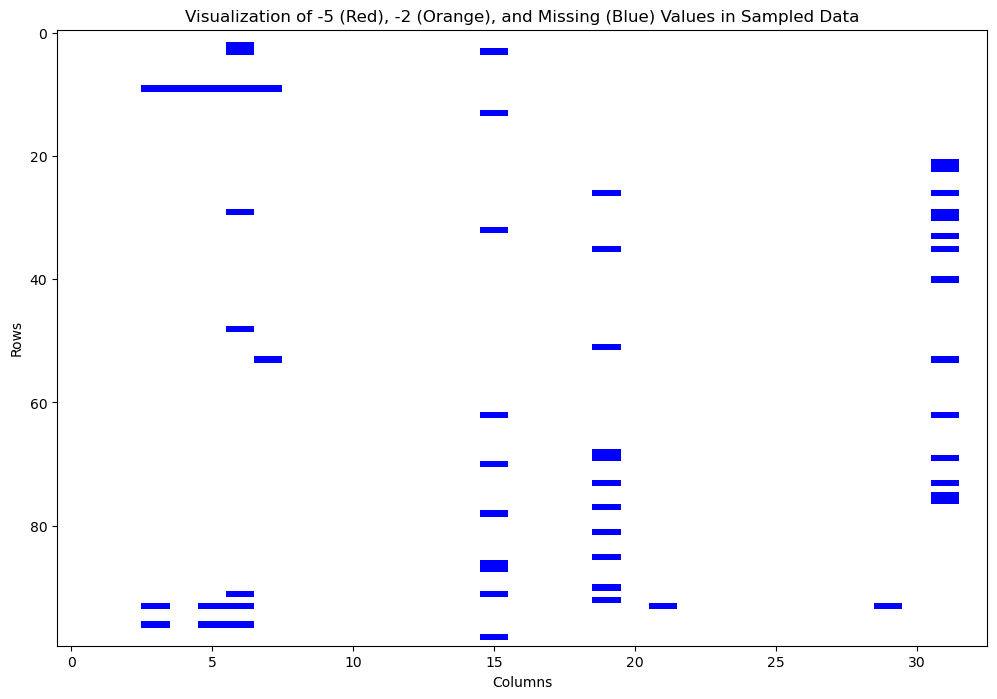

In [2]:
visualize_special_values(df)

Correlations

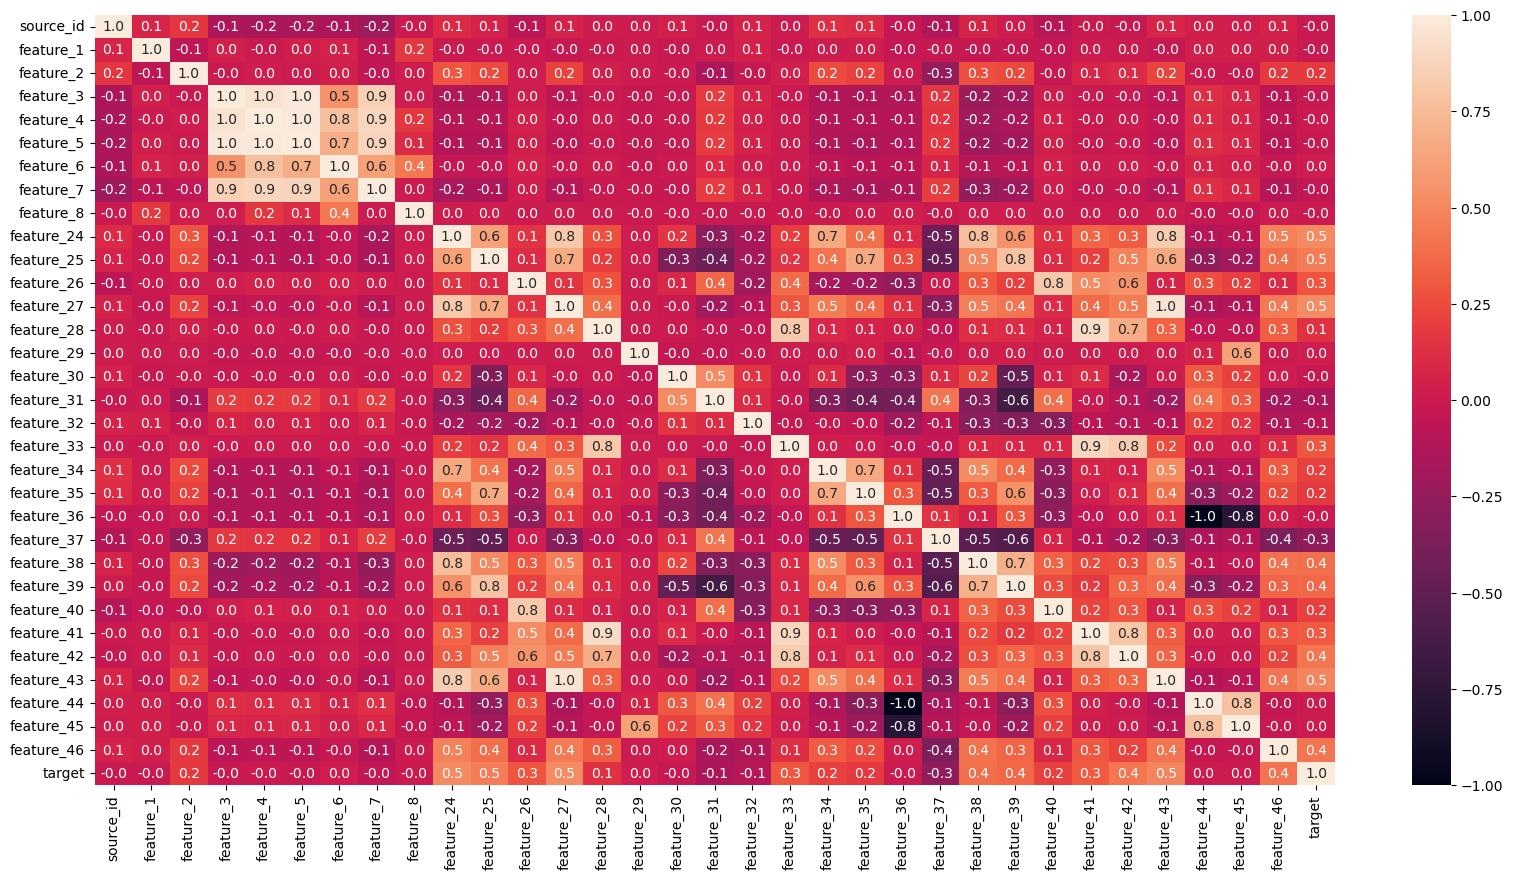

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set the figure size for a larger heatmap
plt.figure(figsize=(20, 10))  # You can adjust the size as needed
# Create a heatmap with annotations and larger font size
sns.heatmap(df.corr(), annot=True, fmt=".1f",)
# Show the plot
plt.show()

Analyzing two rows corresponding to the same target

In [4]:
rows = df.iloc[40288:40290]
differences = rows.iloc[0] != rows.iloc[1]
different_columns = rows.columns[differences]

# Display the columns that are different
cols = list(rows[different_columns].dropna(how="all", axis = 1).columns) + ["target"]
rows[cols]

,feature_27,feature_28,feature_32,feature_33,feature_36,feature_37,feature_44,feature_45,target
40288,19350.283,45093.691,-3.712472,52203.915507,-3.609604,-4.716771,-3.390396,-6.390396,3205
40289,17354.887,33898.513,-3.463886,63399.093507,-3.954752,-4.738917,-3.045248,-6.045248,3205


EDA

Showing only a few features here for convenience

Column: source_id
source_id
10    5319
13    4709
6     3636
19    3116
7     2698
4     2122
15    2037
16    1845
1     1777
17    1699
18    1480
11    1436
2     1359
0     1142
14    1131
8     1074
3      955
5      949
12     927
9      881
Name: count, dtype: int64
Missing Vals =  0.0
Unique Vals =  20


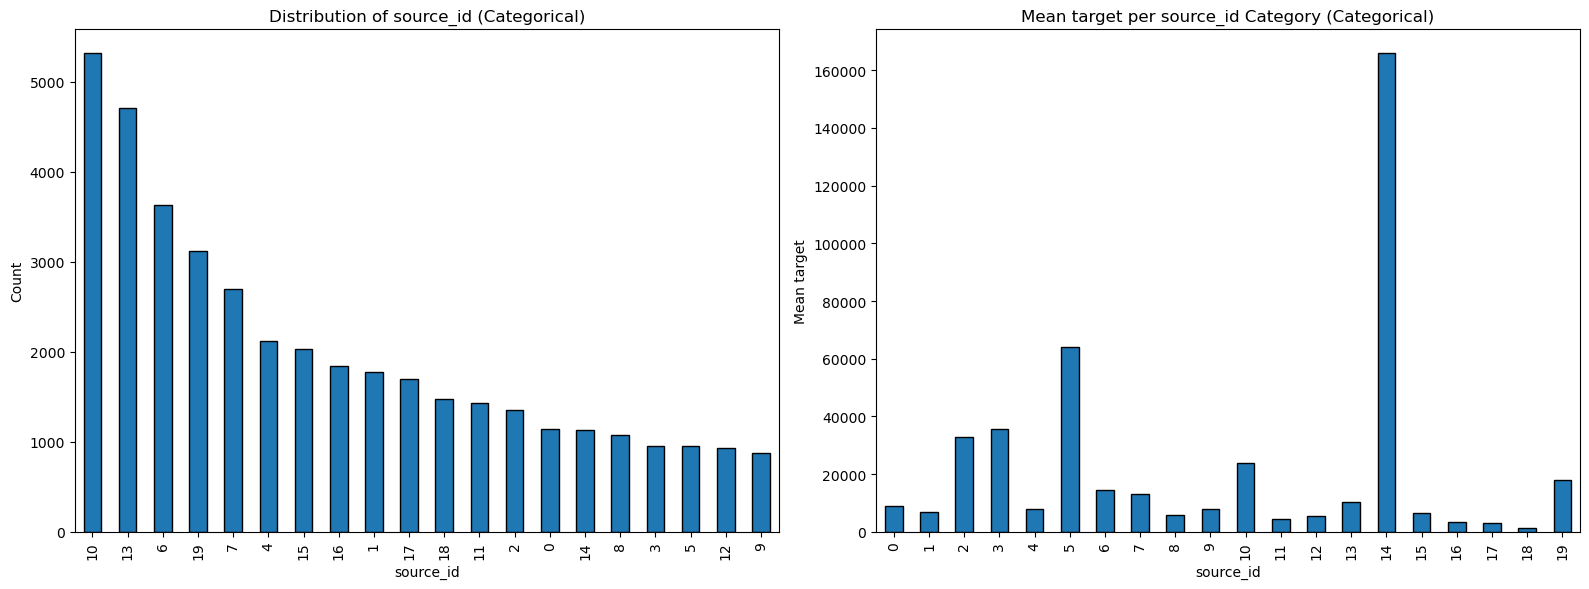

####################################################################################################
Column: feature_6
feature_6
280.00     5322
400.00     4918
10.00      4170
475.00     3551
595.00     3067
           ... 
307.00        1
6115.00       1
1570.00       1
4782.46       1
472.00        1
Name: count, Length: 73, dtype: int64
Missing Vals =  0.12086766603792316
Unique Vals =  73


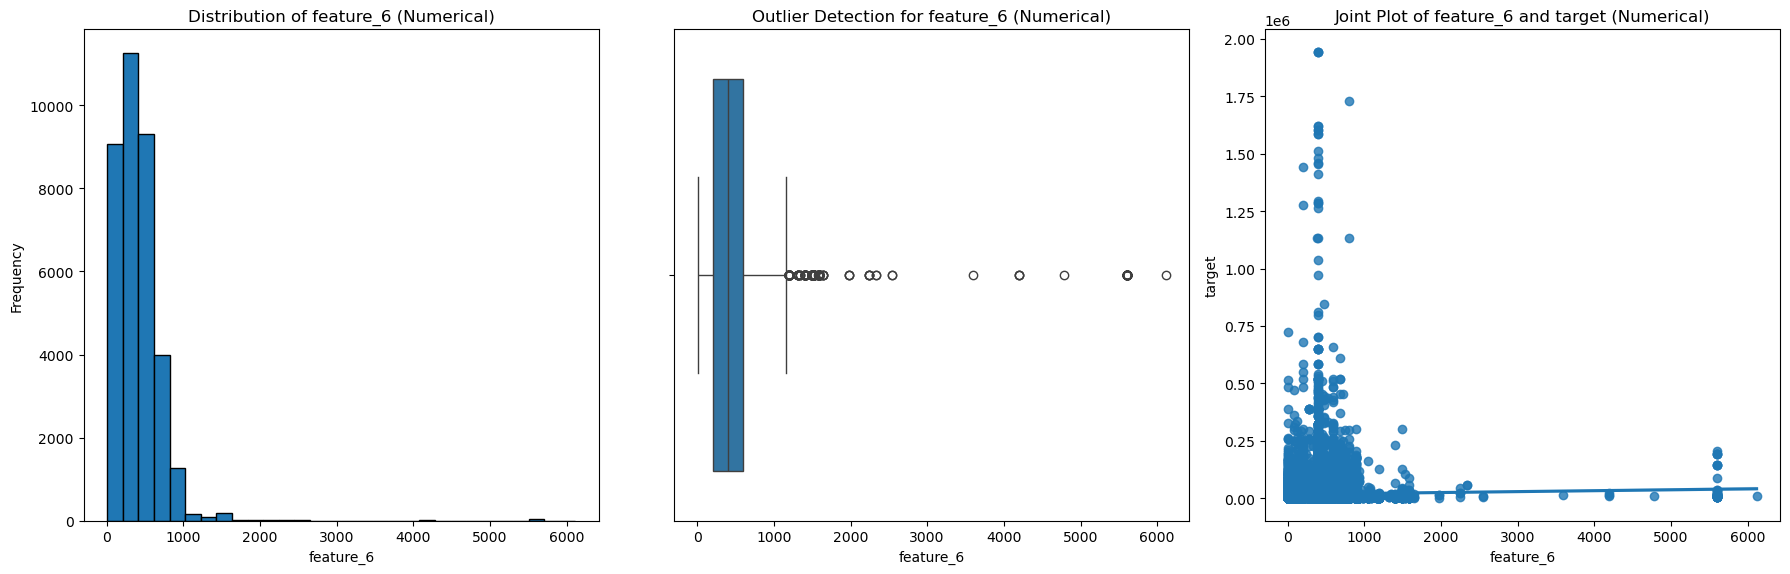

Correlation with target: 0.023159710885319033
High correlation between feature_6 and feature_3: 0.5482745948372824
High correlation between feature_6 and feature_4: 0.7719828361524603
High correlation between feature_6 and feature_5: 0.6829856397658752
High correlation between feature_6 and feature_7: 0.6229825206364168
####################################################################################################


In [9]:
# Updated script to include column type (categorical/numerical) in plot titles

# Assuming df and target are already loaded
target = 'target'  # Replace with the actual name of the target column

# Lists to store numerical and categorical column names
numerical_columns = []
categorical_columns = []

# Initialize a list to store highly correlated columns
multicollinear_columns = []

# Iterate through columns, excluding the target column
for col in df.columns[::3]:
    df_col = df[col]
    if df_col.nunique() < 100:
        # Print column stats
        print(f"Column: {col}")
        print(df_col.value_counts())
        print("Missing Vals = ", df_col.isnull().mean())
        print("Unique Vals = ", df_col.nunique())

        # Heuristic to determine if a column is numerical or categorical
        column_type = column_classifications[col]

        if column_type == 'Numerical':
            # Create subplots for numerical columns
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
            
            # Histogram
            axs[0].hist(df[col], bins=30, edgecolor='black')
            axs[0].set_title(f'Distribution of {col} (Numerical)')
            axs[0].set_xlabel(col)
            axs[0].set_ylabel('Frequency')

            # Boxplot for outliers
            sns.boxplot(x=df[col], ax=axs[1])
            axs[1].set_title(f'Outlier Detection for {col} (Numerical)')

            # Jointplot
            sns.regplot(x=df[col], y=df[target], ax=axs[2])
            axs[2].set_title(f'Joint Plot of {col} and {target} (Numerical)')
            
            plt.tight_layout()
            plt.show()

            # Correlation with the target
            correlation_with_target = df[col].corr(df[target])
            print(f"Correlation with target: {correlation_with_target}")

        else:
            # Create subplots for categorical columns
            fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

            # Bar chart
            df[col].value_counts().plot(kind='bar', edgecolor='black', ax=axs[0])
            axs[0].set_title(f'Distribution of {col} (Categorical)')
            axs[0].set_xlabel(col)
            axs[0].set_ylabel('Count')

            # Mean target per category
            mean_target_per_category = df.groupby(col)[target].mean()
            mean_target_per_category.plot(kind='bar', edgecolor='black', ax=axs[1])
            axs[1].set_title(f'Mean {target} per {col} Category (Categorical)')
            axs[1].set_xlabel(col)
            axs[1].set_ylabel(f'Mean {target}')
            
            plt.tight_layout()
            plt.show()

        # Check for multicollinearity
        if column_type == 'Numerical':
            for other_col in df.columns:
                if other_col != col and pd.api.types.is_numeric_dtype(df[other_col]):
                    correlation = df[col].corr(df[other_col])
                    if abs(correlation) > 0.5:
                        multicollinear_columns.append((col, other_col, correlation))
                        print(f"High correlation between {col} and {other_col}: {correlation}")

        print("#" * 100)

Model Selection

I tried log transforms on the input and target, anomaly removal (IQR), winsorization, different imputations, PCA, target encoding, model ensembling etc. and trained some models. (I am omitting most of these here for simplicity).

CatBoost worked by far the best on all settings so I decided to move forward with that.

I was already expecting this as it is very robust with inputs that have multicollinearity, skewness, categorical values, and missing values which is the case here.

I expected more from the linear models as there are high linear correlations, but the best I got was around 60-70% R2.

So ensembling models didn't improve performance and I decided to move forward with CatBoost only.


Linear Regression
RMSE: 38329.9914
R2: 0.4272


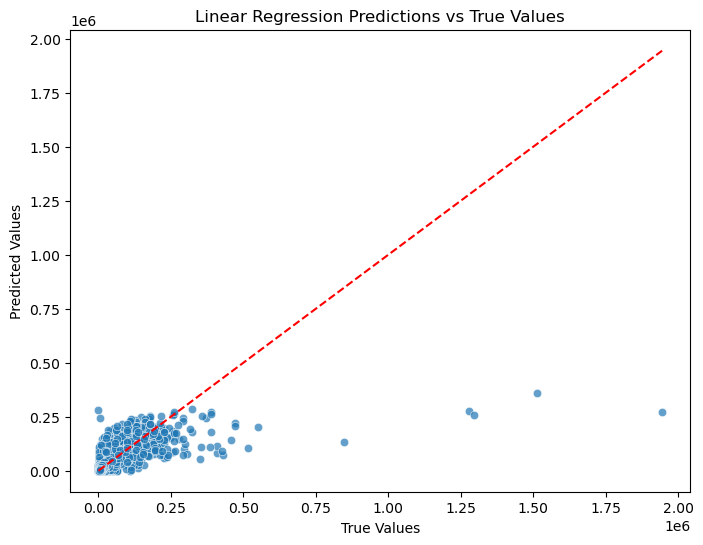

C:\Users\taylan\AppData\Local\Temp\ipykernel_20756\3843678076.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(coefficients)[sorted_idx], y=X.columns[sorted_idx], palette="coolwarm")


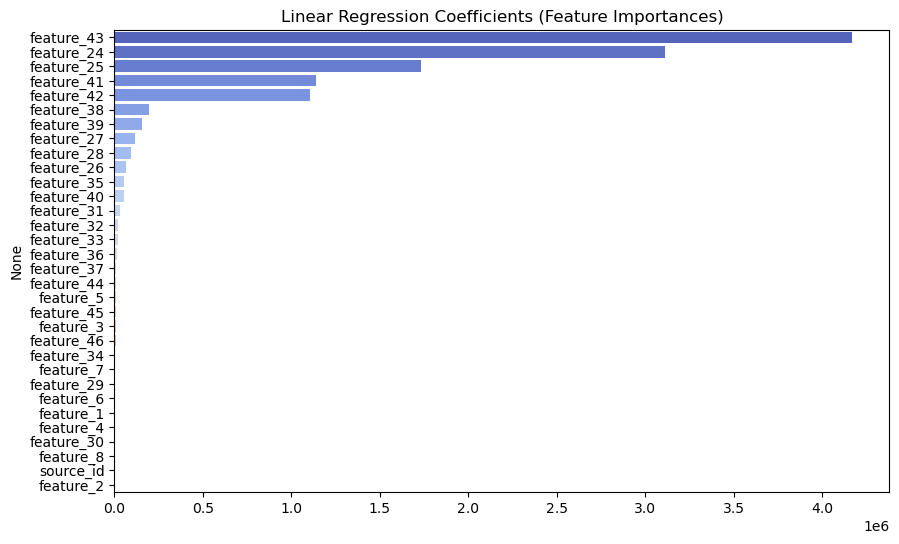


Random Forest
RMSE: 24036.6198
R2: 0.7748


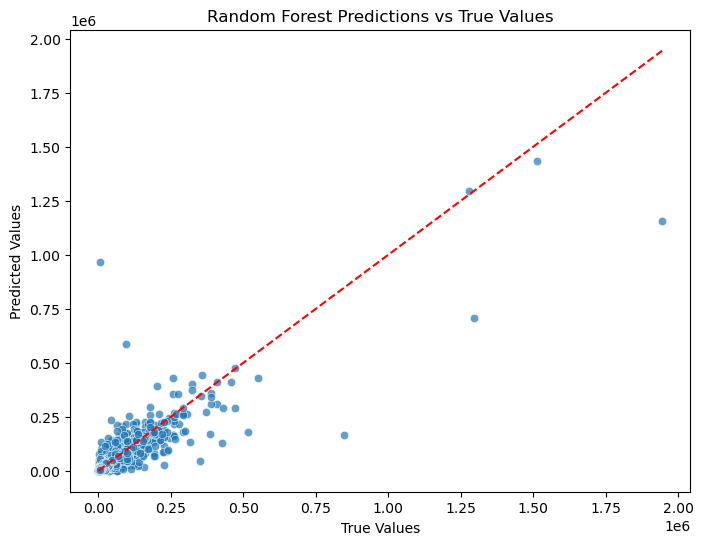

C:\Users\taylan\AppData\Local\Temp\ipykernel_20756\3843678076.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=X.columns[sorted_idx], palette="coolwarm")


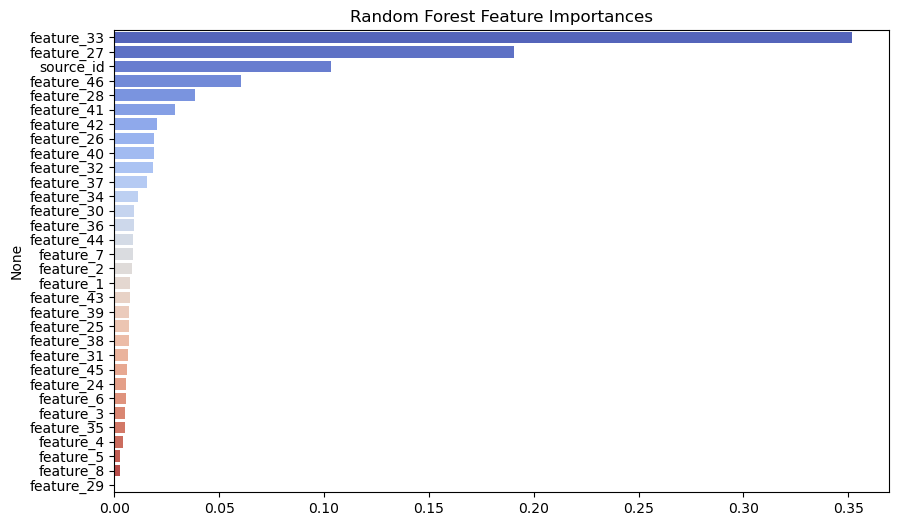


CatBoost
RMSE: 19260.6032
R2: 0.8554


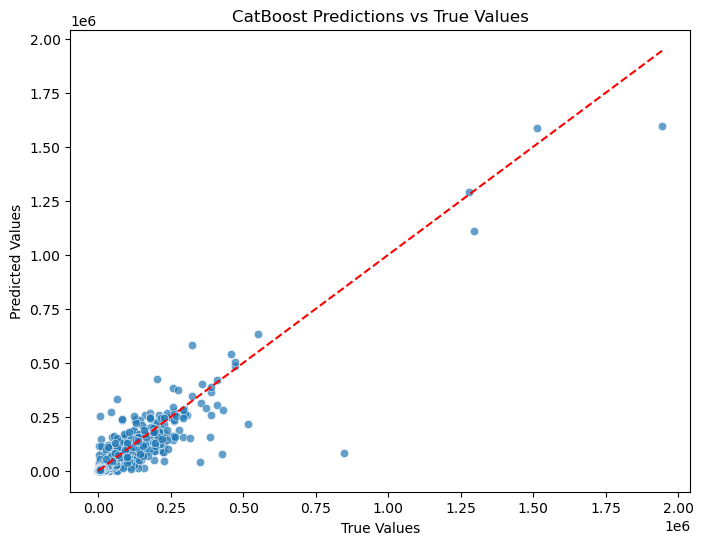

C:\Users\taylan\AppData\Local\Temp\ipykernel_20756\3843678076.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=X.columns[sorted_idx], palette="coolwarm")


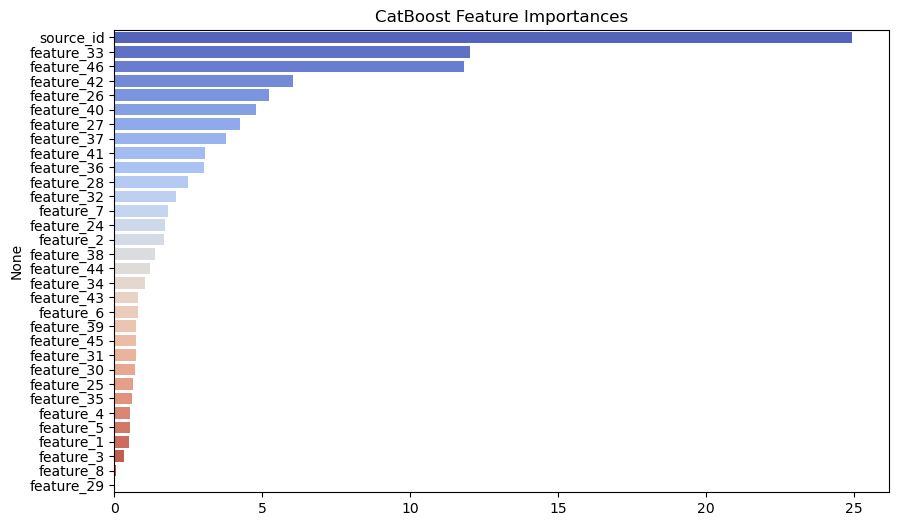


Lasso
RMSE: 39139.5057
R2: 0.4028


c:\Users\taylan\anaconda3\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.007e+13, tolerance: 1.009e+10
  model = cd_fast.enet_coordinate_descent(


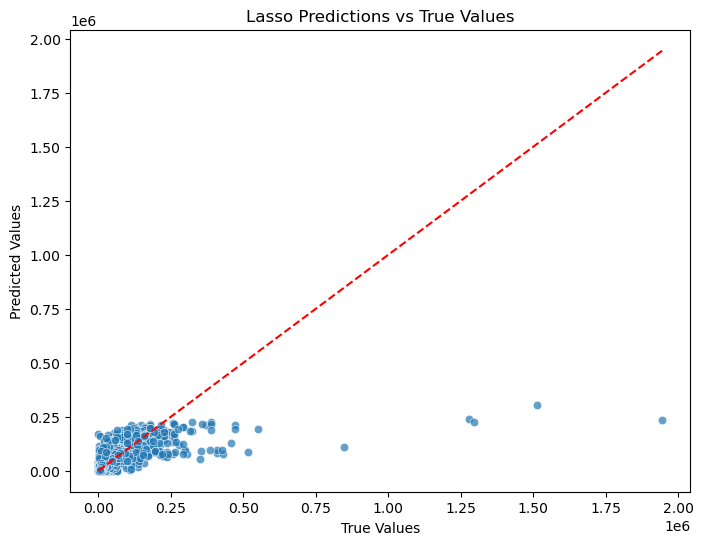

C:\Users\taylan\AppData\Local\Temp\ipykernel_20756\3843678076.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(coefficients)[sorted_idx], y=X.columns[sorted_idx], palette="coolwarm")


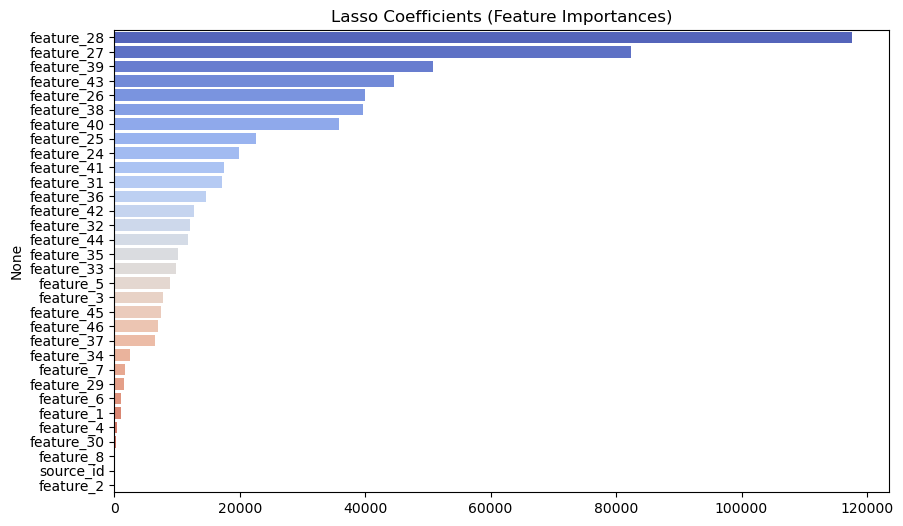


Ridge
RMSE: 39008.3582
R2: 0.4068


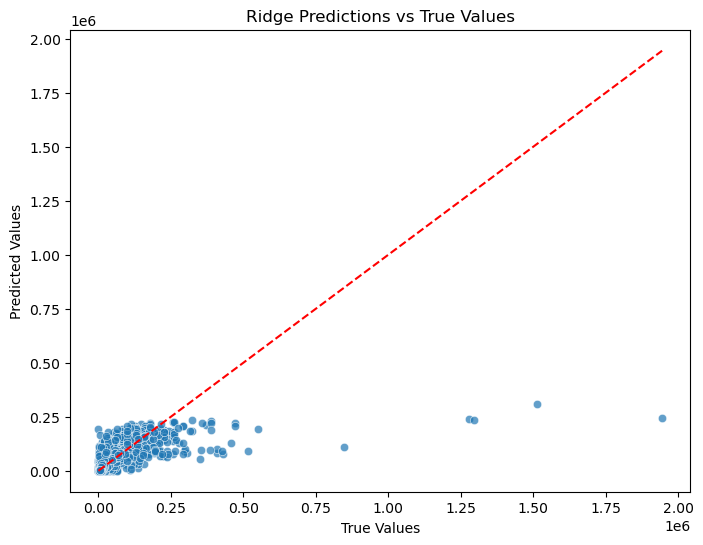

C:\Users\taylan\AppData\Local\Temp\ipykernel_20756\3843678076.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(coefficients)[sorted_idx], y=X.columns[sorted_idx], palette="coolwarm")


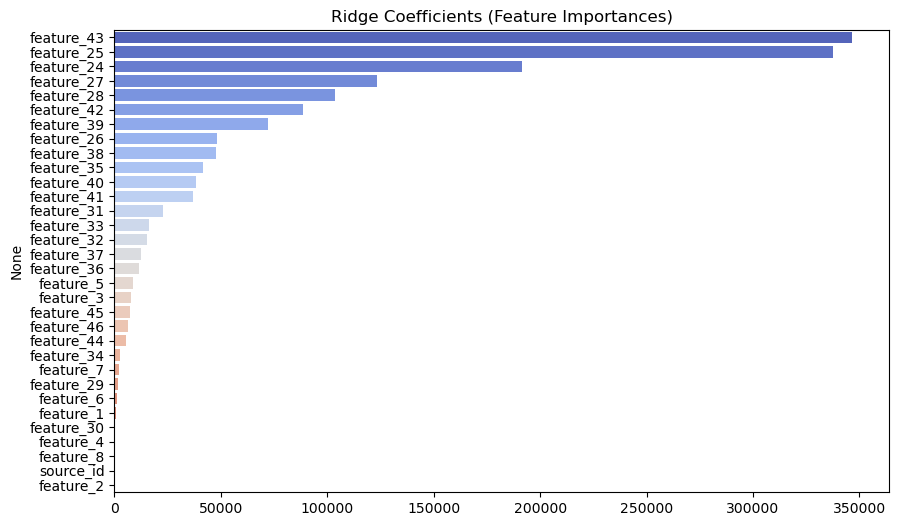


ElasticNet
RMSE: 40849.5922
R2: 0.3494


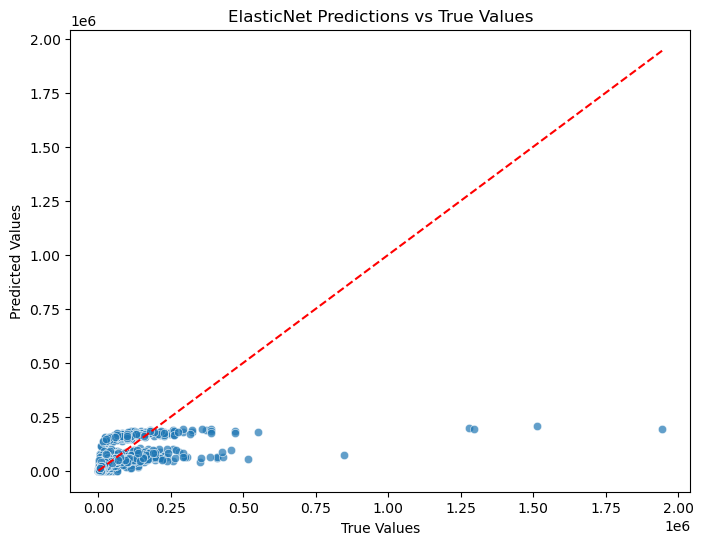

C:\Users\taylan\AppData\Local\Temp\ipykernel_20756\3843678076.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(coefficients)[sorted_idx], y=X.columns[sorted_idx], palette="coolwarm")


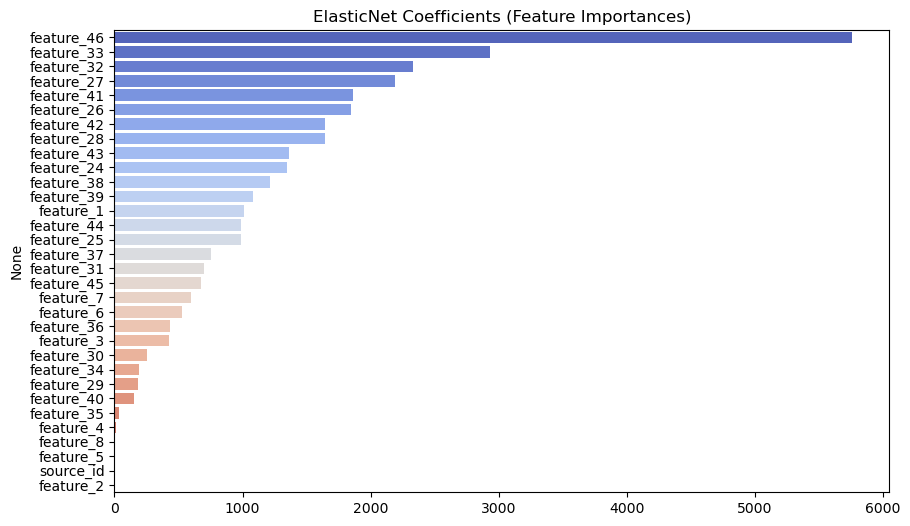


K-Nearest Neighbors
RMSE: 35820.6189
R2: 0.4998


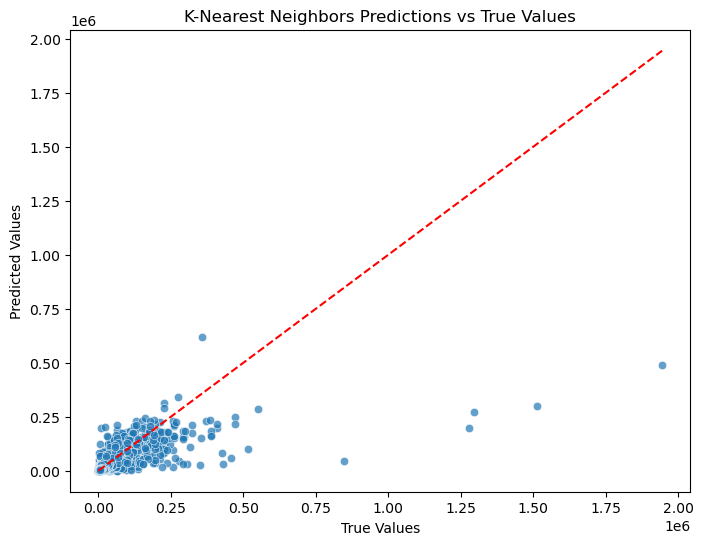


Model Comparison:
                 Model          RMSE        R2
0    Linear Regression  38329.991388  0.427225
1        Random Forest  24036.619810  0.774756
2             CatBoost  19260.603205  0.855374
3                Lasso  39139.505671  0.402776
4                Ridge  39008.358199  0.406772
5           ElasticNet  40849.592216  0.349448
6  K-Nearest Neighbors  35820.618857  0.499767


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

# Adding KNeighborsRegressor to the list of models
#final_df = impute_data(df, num_cols=num_cols, cat_cols=cat_cols)
log_transform = True
target_transform = False

# Function to evaluate and print results
def evaluate_model(model, X_train, X_test, y_train, y_test, target_transform=False):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Reverse target transformation if applied
    if target_transform:
        y_pred = np.expm1(y_pred)

    y_pred = np.clip(y_pred, 1, np.inf)

    # Calculate RMSE and R²
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'RMSE: {rmse:.4f}')
    print(f'R2: {r2:.4f}')
    
    return model, rmse, r2, y_pred

df = impute_data(df, num_cols, cat_cols)



# Step 1: Prepare the data
X = df.drop(columns=['target'])
num_cols.remove("target") if "target" in num_cols else None

if log_transform:
    for col in num_cols:
        X[col] = np.log1p(X[col] + abs(X[col].min()) + 1)  # Shift values to make them positive

if cat_cols[0] in X.columns:
    X[cat_cols] = X[cat_cols].astype(str)

y = df['target']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Target Encode categorical features
X_train, X_test = target_encoder(X_train, X_test, y_train, cat_cols)

#X_train = impute_data(X_train, num_cols, cat_cols)
#X_test = impute_data(X_test, num_cols, cat_cols)

scaler = StandardScaler()

# Fit on the training data and transform both training and test sets
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

if target_transform:
    y_train = np.log1p(y_train)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0), #cat_features=cat_cols if cat_cols[0] in X.columns else None),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'K-Nearest Neighbors' : KNeighborsRegressor(),
}

results = []

# Step 2: Loop over models to train and evaluate each one
for name, model in models.items():
    print(f'\n{name}')
    model, rmse, r2, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test, target_transform)
    results.append((name, rmse, r2))
    
    # Plot predictions vs y_test
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name} Predictions vs True Values')
    plt.show()
    
    # Print feature importances where applicable
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        sorted_idx = np.argsort(feature_importances)[::-1]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances[sorted_idx], y=X.columns[sorted_idx], palette="coolwarm")
        plt.title(f'{name} Feature Importances')
        plt.show()
    elif hasattr(model, 'coef_'):
        coefficients = model.coef_
        sorted_idx = np.argsort(np.abs(coefficients))[::-1]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=np.abs(coefficients)[sorted_idx], y=X.columns[sorted_idx], palette="coolwarm")
        plt.title(f'{name} Coefficients (Feature Importances)')
        plt.show()

# Step 3: Display results comparison
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R2'])
print("\nModel Comparison:")
print(results_df)
